In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

2022-07-26 14:54:37.749237: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [6]:
# Specify data URI
URI = 'ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.62,808.5,367.5,220.50,3.5,2,0.00,0,8.60,12.07
1,0.98,514.5,294.0,110.25,7.0,3,0.25,4,28.55,29.59
2,0.69,735.0,294.0,220.50,3.5,4,0.40,2,14.33,17.23
3,0.79,637.0,343.0,147.00,7.0,5,0.25,2,38.98,45.97
4,0.79,637.0,343.0,147.00,7.0,4,0.40,1,42.50,38.35


In [8]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

In [9]:
train_stats

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.761417,674.149023,320.056189,177.046417,5.227199,3.506515,0.233958,2.814332,22.272827,24.533339
std,0.106344,88.724992,44.171027,45.287610,1.751278,1.123292,0.133435,1.562631,10.135332,9.523494
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000,10.900000
25%,0.660000,612.500000,294.000000,128.625000,3.500000,3.000000,0.100000,1.000000,12.977500,15.575000
50%,0.740000,686.000000,318.500000,220.500000,3.500000,3.500000,0.250000,3.000000,18.595000,21.610000
75%,0.820000,759.500000,343.000000,220.500000,7.000000,5.000000,0.400000,4.000000,31.652500,32.957500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000,48.030000


In [10]:
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.761417,0.106344,0.62,0.660,0.74,0.82,0.98
X2,614.0,674.149023,88.724992,514.50,612.500,686.00,759.50,808.50
X3,614.0,320.056189,44.171027,245.00,294.000,318.50,343.00,416.50
X4,614.0,177.046417,45.287610,110.25,128.625,220.50,220.50,220.50
X5,614.0,5.227199,1.751278,3.50,3.500,3.50,7.00,7.00
X6,614.0,3.506515,1.123292,2.00,3.000,3.50,5.00,5.00
X7,614.0,0.233958,0.133435,0.00,0.100,0.25,0.40,0.40
X8,614.0,2.814332,1.562631,0.00,1.000,3.00,4.00,5.00


In [11]:
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [13]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

In [15]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

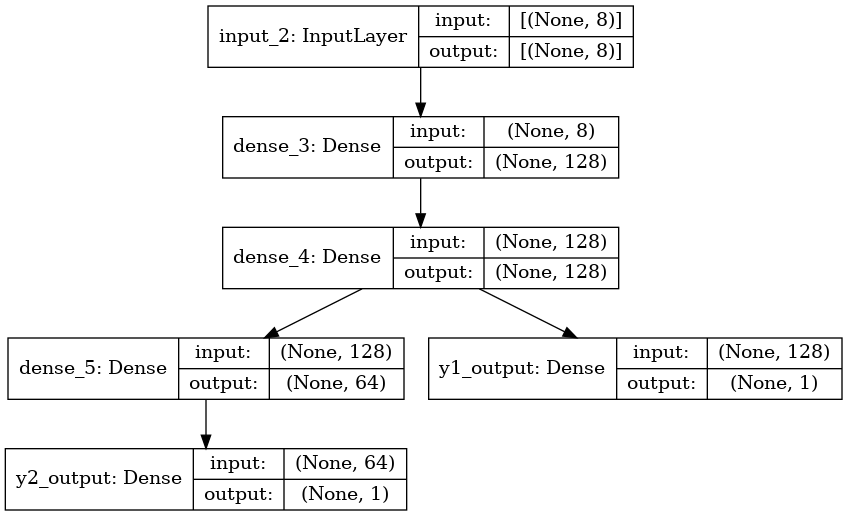

In [20]:
# Plot model graph
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multiOuput.png')

In [16]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=100, batch_size=10, validation_data=(norm_test_X, test_Y))

2022-07-26 15:01:39.226729: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-26 15:01:39.256239: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


Epoch 1/100


2022-07-26 15:01:39.860570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


31/62 [==============>...............] - ETA: 0s - loss: 452.9904 - y1_output_loss: 211.7156 - y2_output_loss: 241.2748 - y1_output_root_mean_squared_error: 14.5504 - y2_output_root_mean_squared_error: 15.5330     

2022-07-26 15:01:42.438791: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


62/62 [==============================] - 3s 4ms/step - loss: 247.5217 - y1_output_loss: 114.6583 - y2_output_loss: 132.8635 - y1_output_root_mean_squared_error: 10.7079 - y2_output_root_mean_squared_error: 11.5266 - val_loss: 33.9839 - val_y1_output_loss: 14.8049 - val_y2_output_loss: 19.1790 - val_y1_output_root_mean_squared_error: 3.8477 - val_y2_output_root_mean_squared_error: 4.3794
Epoch 2/100
62/62 [==============================] - 0s 2ms/step - loss: 31.7684 - y1_output_loss: 12.8291 - y2_output_loss: 18.9393 - y1_output_root_mean_squared_error: 3.5818 - y2_output_root_mean_squared_error: 4.3519 - val_loss: 49.6007 - val_y1_output_loss: 14.6008 - val_y2_output_loss: 35.0000 - val_y1_output_root_mean_squared_error: 3.8211 - val_y2_output_root_mean_squared_error: 5.9161
Epoch 3/100
62/62 [==============================] - 0s 2ms/step - loss: 27.5458 - y1_output_loss: 10.5932 - y2_output_loss: 16.9525 - y1_output_root_mean_squared_error: 3.2547 - y2_output_root_mean_squared_error:

In [17]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 5.1606 - y1_output_loss: 0.6101 - y2_output_loss: 4.5505 - y1_output_root_mean_squared_error: 0.7811 - y2_output_root_mean_squared_error: 2.1332
Loss = 5.160560607910156, Y1_loss = 0.6100807785987854, Y1_mse = 0.7810766696929932, Y2_loss = 4.550479412078857, Y2_mse = 2.133185386657715


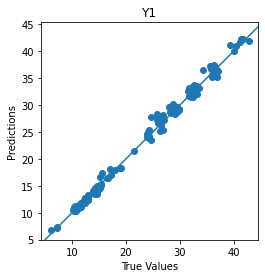

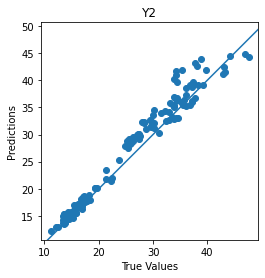

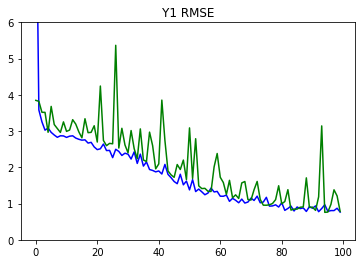

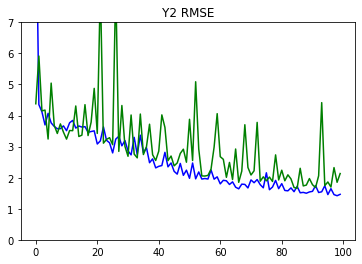

In [18]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)